In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
data_path = "/workspaces/deteccion_clientes_banco/data/df_resampled.csv"
df = pd.read_csv(data_path, sep=",")
df

,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_freq_encode,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,y
0,56,5,1,261,1,999,0,1.1,93.994000,-36.400000,...,0.101389,1,0,0,1,0,0,0,1,0
1,57,5,1,149,1,999,0,1.1,93.994000,-36.400000,...,0.231014,1,0,0,1,0,0,0,1,0
2,37,5,1,226,1,999,0,1.1,93.994000,-36.400000,...,0.231014,0,0,1,1,0,0,0,1,0
3,40,5,1,151,1,999,0,1.1,93.994000,-36.400000,...,0.055647,1,0,0,1,0,0,0,1,0
4,56,5,1,307,1,999,0,1.1,93.994000,-36.400000,...,0.231014,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46543,84,4,2,166,1,6,2,-1.8,93.749000,-34.600000,...,0.105316,0,0,0,1,0,0,0,0,1
46544,38,7,2,273,1,999,0,-1.7,94.215000,-40.300000,...,0.231014,0,0,0,1,0,0,0,0,1
46545,27,5,3,851,1,999,0,-1.8,92.893000,-46.200000,...,0.231014,0,0,0,1,0,0,1,0,1
46546,49,9,1,208,1,999,1,-3.4,92.399729,-28.643943,...,0.135057,0,0,0,0,0,1,1,0,1


## Training

In [13]:
def entrenar(modelo, data):
    train, test = train_test_split(data, test_size = 0.2, random_state = 42)
    X_train = train.drop("y", axis = 1)
    Y_train = train["y"]

    X_test = test.drop("y", axis = 1)
    Y_test = test["y"]

    if modelo == "Random Forest":
        rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
        rf_model.fit(X_train, Y_train)
        y_pred = rf_model.predict(X_test)
        y_prob = rf_model.predict_proba(X_test)[:, 1]

    if modelo == "XGBoost":
        xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, Y_train)
        y_pred = xgb_model.predict(X_test)
        y_prob = xgb_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nF1: {f1}")
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")

    fpr, tpr, _ = roc_curve(Y_test, y_prob)
    roc_auc = roc_auc_score(Y_test, y_prob)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Random Forest")
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.9254564983888293
Recall: 0.8136272545090181
Precision: 0.8345323741007195
F1: 0.823947234906139


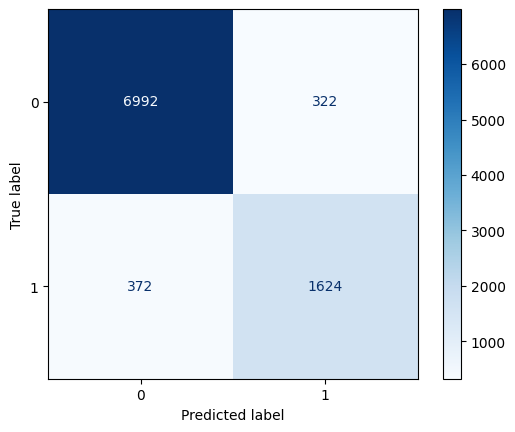

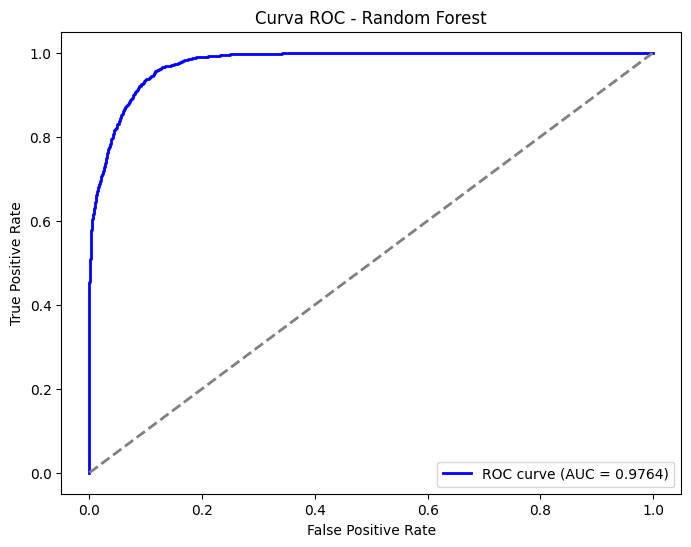

In [14]:
entrenar("XGBoost", df)

Accuracy: 0.9165413533834587
Recall: 0.7895791583166333
Precision: 0.8153129849974133
F1: 0.8022397556630185


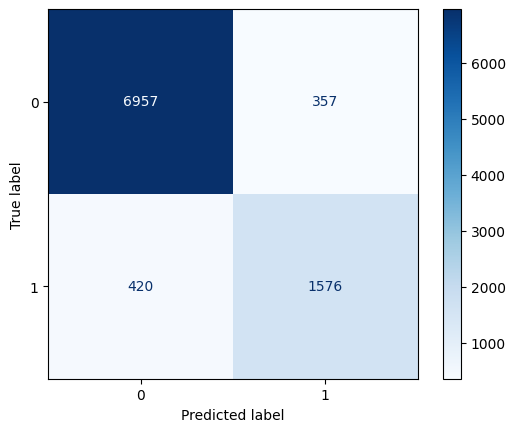

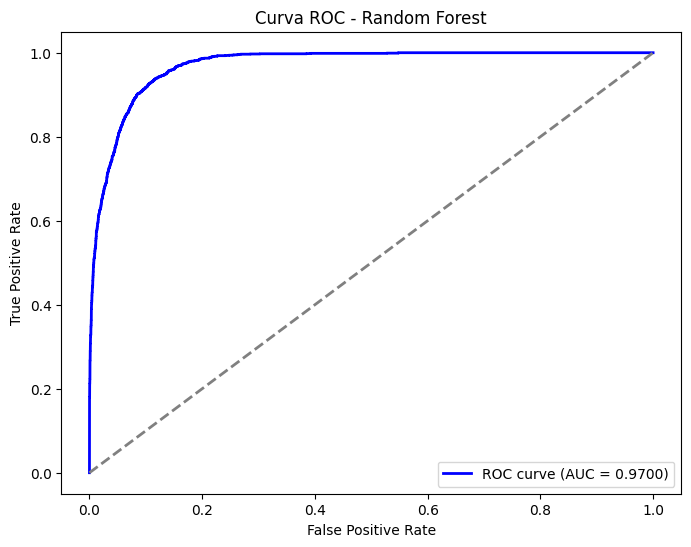

In [9]:
entrenar("Random Forest", df)

### Métricas sin Oversampling (36000, 4000)

Accuracy: 0.91

Recall: 0.39

Precision: 0.69

F1: 0.50

### Métricas con Oversampling (36000, 10000)

Accuracy: 0.91

Recall: 0.78

Precision: 0.81

F1: 0.80